# SNOTEL decay date determination

Use period of record SWE data from individual SNOTEL sites (downloaded with) to determine dates of peak SWE and snow all gone for input to watershed_awsm_year.ini

*J. Michelle Hu  
University of Utah  
June 2024*  
---

In [1]:
import os
import sys
import xarray as xr
import numpy as np

from pathlib import PurePath
import pandas as pd
import hvplot.xarray
import rioxarray as riox
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/work/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# # Set environmental variable for PROJ to directory where you can find proj.db
# os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
# os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

## Setup

In [15]:
# SNOTEL PoR directory
snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'

# Specify water year
WY = 2023

# Specify snotel site numbers
sitenums = [485, 531, 415, 505] # Fremont Pass, Hoosier Pass, Copper Mountain, Grizzly Peak

snotel_fns = [h.fn_list(snotel_dir, f'*{sitenum}*.csv')[0] for sitenum in sitenums]
snotel_fns

['/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/20240621_PoR_site485.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/20240621_PoR_site531.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/20240621_PoR_site415.csv',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/20240621_PoR_site505.csv']

In [16]:
# Read in each PoR file as dataframe and subset to specified water year
snotel_df_list = []
for snotel_fn in snotel_fns:
    
    df = pd.read_csv(snotel_fn, skiprows=63, usecols=list(np.arange(0, 7)), parse_dates=["Date"])
    
    # Copy date to new date indexing column
    df['DateIndex'] = df['Date']

    # reset index as Date
    df = df.set_index('DateIndex')

    # Clip to this water year
    snotel_df = df[(df['Date']>=f'{int(WY) - 1}-10-01') & (df['Date']<f'{WY}-10-01')]
    
    # Extract the site name
    sitename = f'{snotel_df.columns[1].split(")")[0]})'
    print(sitename)
    
    # Extract the SWE column
    swe_colname = f'{sitename} Snow Water Equivalent (mm) End of Day Values'
    snotel_df = snotel_df[swe_colname]
    
    snotel_df_list.append(snotel_df)

Fremont Pass (485)
Hoosier Pass (531)
Copper Mountain (415)
Grizzly Peak (505)


Fremont Pass (485) Snow Water Equivalent (mm) End of Day Values
Hoosier Pass (531) Snow Water Equivalent (mm) End of Day Values
Copper Mountain (415) Snow Water Equivalent (mm) End of Day Values
Grizzly Peak (505) Snow Water Equivalent (mm) End of Day Values


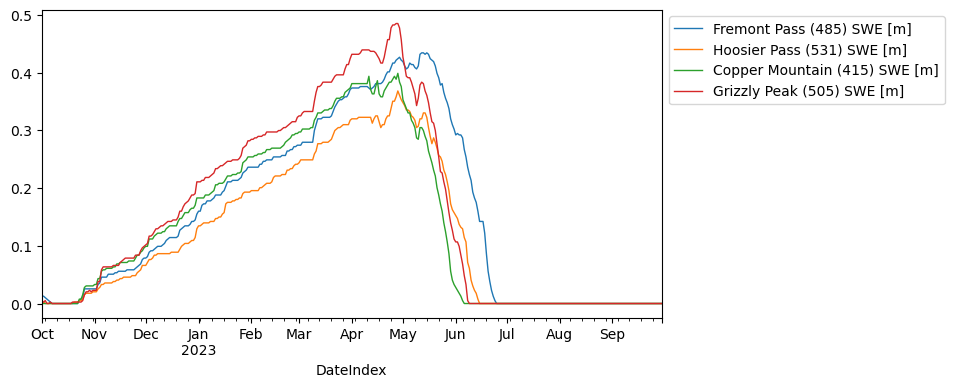

In [17]:
linestyle = '-' #':'
linewidth = 1
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']

# Grab PoR csv and read in the proper WY
figsize = (8, 4)
fig, ax = plt.subplots(1, 1, figsize=figsize)

for df in snotel_df_list:
    print(df.name)
    
    # Plot WY time series of snow depth
    (df/1000).plot(ax=ax, 
                  label=f'{df.name.split(" Snow")[0]} SWE [m]', 
                  linestyle=linestyle, 
                  linewidth=linewidth, 
                  # color=snotelcolors[0], 
                  marker=marker)
plt.legend(bbox_to_anchor=(1,1))

In [18]:
# # Locate date of peak SWE 
# peak_date, max_val = proc.calc_peak(df/1000, snow_name='SWE', verbose=True)

In [19]:
# # Locate date of swe all gone
# snotel_sdd, snotel_grad = proc.calc_sdd(df, snow_name='SWE', verbose=True)

In [20]:
for df in snotel_df_list:
    print(df.name.split(' Snow')[0])
    peak_date, max_val = proc.calc_peak(df/1000, snow_name='SWE', verbose=True)
    # print('\n')
    snotel_sdd, snotel_grad = proc.calc_sdd(df, snow_name='SWE', verbose=True)
    print('\n')

Fremont Pass (485)
Peak SWE date: 2023-05-12
Peak SWE value: 0.4343 m
Snow all gone date 2023-06-25
Derivative: -5.902777777777777e-05 m/d
SWE: 0.0 m


Hoosier Pass (531)
Peak SWE date: 2023-04-28
Peak SWE value: 0.3683 m
Snow all gone date 2023-06-15
Derivative: -8.796296296296296e-05 m/d
SWE: 0.0 m


Copper Mountain (415)
Peak SWE date: 2023-04-28
Peak SWE value: 0.3988 m
Snow all gone date 2023-06-06
Derivative: -5.902777777777777e-05 m/d
SWE: 0.0 m


Grizzly Peak (505)
Peak SWE date: 2023-04-27
Peak SWE value: 0.48510000000000003 m
Snow all gone date 2023-06-09
Derivative: -5.902777777777777e-05 m/d
SWE: 0.0 m


